# Fake news prediction model

## Dependencies

In [216]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

## Data processing

### Loading the cleaned data

In [217]:
chunk_size = 1000
rows = 868346
chunks = []

# * Load csv file with tqdm for tracking progress
with tqdm(desc="Loading csv file", total=rows) as pbar:
    for chunk in pd.read_csv("fake_news_dataset/10,000_data_cleaned_fr.csv", chunksize=chunk_size):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)
df = df.dropna(subset=['content', 'type'])

Loading csv file:   1%|          | 9339/868346 [00:00<00:42, 19987.95it/s]


### Distribution

In [218]:
print(f'Total article amount: {len(df['type'])}')
print(f'Fake article amount: {len(df[df['type']=='fake'])}')
print(f'Reliable article amount: {len(df[df['type']=='reliable'])}')
print(f'Reliable percentage: {(len(df[df['type']=='reliable'])/len(df['type'])*100):.2f}%')

Total article amount: 8891
Fake article amount: 0
Reliable article amount: 0
Reliable percentage: 0.00%


# Simple model

We will try to add the cleaned BBC dataset to our current one, and see how the model performs.

In [219]:
df2 = pd.read_csv('bbc_dataset/bbc_cleaned_fr.csv')

# Concatenate vertically (stacking rows)
merged_df = pd.concat([df, df2], ignore_index=True)

merged_df.to_csv('bbc_dataset/merged_data.csv', index=False)

### Splitting

In [220]:
merged_df['type'] = merged_df['type'].astype(str)

X = merged_df['content']
y = merged_df['type'] 

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42, 
    stratify=y
)

In [ ]:
#X_train = pd.concat([X_train, df2], ignore_index=True)

# Check class distribution
print("\nClass distribution in training set:")
class_counts = y_train.value_counts()
print(class_counts)
print(class_counts / len(y_train) * 100)

# Create feature extraction pipeline with n-grams
feature_extraction = Pipeline([
    ('vect', CountVectorizer(
        max_features=10000,             # Limit to top 5,000 features
    )),
    #('tfidf', TfidfTransformer()),
])

# Apply feature extraction to training data
X_train_features = feature_extraction.fit_transform(X_train)
print(f"\nFeature matrix shape: {X_train_features.shape}")

# Find the minimum number of samples in any class
min_class_count = min(class_counts)
print(f"Minimum class count: {min_class_count}")


smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_features, y_train)

# Show class distribution after resampling
print("\nClass distribution after resampling:")
unique, counts = np.unique(y_train_resampled, return_counts=True)
for class_label, count in zip(unique, counts):
    print(f"Class {class_label}: {count} samples ({count/len(y_train_resampled)*100:.2f}%)")

# Train the logistic regression model on the resampled data
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_resampled, y_train_resampled)


Class distribution in training set:
type
1.0    5270
0.0    2971
Name: count, dtype: int64
type
1.0    63.94855
0.0    36.05145
Name: count, dtype: float64

Feature matrix shape: (8241, 10000)
Minimum class count: 2971

Class distribution after resampling:
Class 0.0: 5270 samples (50.00%)
Class 1.0: 5270 samples (50.00%)


LogisticRegression(max_iter=1000)

# Advanced model

### Splitting

In [222]:
X = df['content']
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

### Vectorization

In [223]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("Original training class distribution:")
print(y_train.value_counts())
print("Test class distribution:")
print(y_test.value_counts())

Original training class distribution:
type
1.0    4316
0.0    2796
Name: count, dtype: int64
Test class distribution:
type
1.0    1079
0.0     700
Name: count, dtype: int64


### Over sampling

In [224]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vectorized, y_train)
print("Resampled training class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Resampled training class distribution:
type
1.0    4316
0.0    4316
Name: count, dtype: int64


## Training and evaluation

### Model training

In [225]:
classifier = MLPClassifier(
    solver='adam',
    alpha=1e-4,
    hidden_layer_sizes=(128, 64, 32),
    shuffle=False,
    random_state=42,
    tol=0.0001,
    verbose=True,
    max_iter=50,
    batch_size=1024,
    learning_rate='adaptive',
    n_iter_no_change=4
)
classifier.fit(X_train_resampled, y_train_resampled)

Iteration 1, loss = 0.72204780
Iteration 2, loss = 0.67579193
Iteration 3, loss = 0.63823215
Iteration 4, loss = 0.58339828
Iteration 5, loss = 0.50799323
Iteration 6, loss = 0.41273302
Iteration 7, loss = 0.31464388
Iteration 8, loss = 0.22340245
Iteration 9, loss = 0.15404501
Iteration 10, loss = 0.10229415
Iteration 11, loss = 0.06595841
Iteration 12, loss = 0.04233340
Iteration 13, loss = 0.02757512
Iteration 14, loss = 0.01879178
Iteration 15, loss = 0.01345519
Iteration 16, loss = 0.01028067
Iteration 17, loss = 0.00829856
Iteration 18, loss = 0.00691535
Iteration 19, loss = 0.00591261
Iteration 20, loss = 0.00517218
Iteration 21, loss = 0.00454502
Iteration 22, loss = 0.00396299
Iteration 23, loss = 0.00351664
Iteration 24, loss = 0.00320350
Iteration 25, loss = 0.00294401
Iteration 26, loss = 0.00273415
Iteration 27, loss = 0.00255724
Iteration 28, loss = 0.00240266
Iteration 29, loss = 0.00226656
Iteration 30, loss = 0.00214929
Iteration 31, loss = 0.00204442
Iteration 32, los

MLPClassifier(batch_size=1024, hidden_layer_sizes=(128, 64, 32),
              learning_rate='adaptive', max_iter=50, n_iter_no_change=4,
              random_state=42, shuffle=False, verbose=True)

# Evaluation

## Simple model

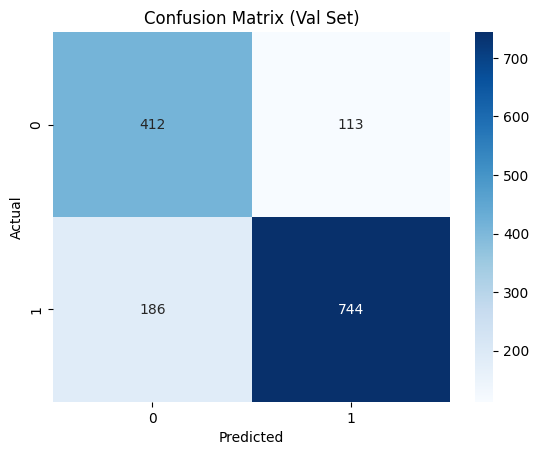


Classification Report for Val Set:
               precision    recall  f1-score   support

         0.0       0.69      0.78      0.73       525
         1.0       0.87      0.80      0.83       930

    accuracy                           0.79      1455
   macro avg       0.78      0.79      0.78      1455
weighted avg       0.80      0.79      0.80      1455



In [232]:
X_val_features = feature_extraction.transform(X_val)
y_pred = clf.predict(X_val_features)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Val Set)')
plt.show()

print("\nClassification Report for Val Set:\n", classification_report(y_val, y_pred))

## Advanced model

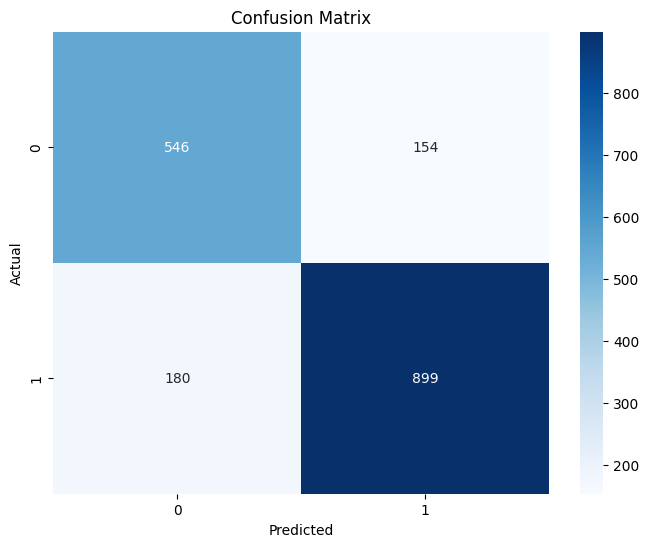

              precision    recall  f1-score   support

         0.0       0.75      0.78      0.77       700
         1.0       0.85      0.83      0.84      1079

    accuracy                           0.81      1779
   macro avg       0.80      0.81      0.80      1779
weighted avg       0.81      0.81      0.81      1779



In [ ]:
y_pred = classifier.predict(X_test_vectorized)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))